In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/glow-tts

In [4]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.1 MB/s 


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys

import librosa
import numpy as np
import os
import glob
import json

import torch
from text import text_to_sequence, cmudict
from text.symbols import symbols
import commons
import attentions
import modules
import models
import utils

In [7]:
# Instantiate Model
model_dir = "/content/drive/MyDrive/glow-tts/checkpoint"
hps = utils.get_hparams_from_dir(model_dir)
model = models.FlowGenerator(
    len(symbols),
    out_channels=hps.data.n_mel_channels,
    **hps.model)


# Loal Checkpoint
#checkpoint_path = /content/glow-tts/checkpoint/G_~~.pth.
utils.load_checkpoint('/content/drive/MyDrive/glow-tts/checkpoint/G_40.pth', model)
model.decoder.store_inverse() # do not calcuate jacobians for fast decoding
_ = model.eval()

cmu_dict = cmudict.CMUDict(hps.data.cmudict_path)

/content/drive/MyDrive/Tacotron/glow-tts/modules.py:200: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2491.)
  w_init = torch.qr(torch.FloatTensor(self.n_split, self.n_split).normal_())[0]


In [8]:
# Text Proprocessing
tst_stn = " 펜안이 이십서 여러분 .전 이 시상에 모든 소굴레와 속박을 벗어데끼난 새 행복을 촛아 떠납니다 . 여러분도 행복헙서 " # Adding spaces at the beginning and the end of utterance improves quality
sequence = np.array(text_to_sequence(tst_stn, ["korean_cleaners"], cmu_dict))[None, :]
print("".join([symbols[c] for c in sequence[0]]))
x_tst = torch.autograd.Variable(torch.from_numpy(sequence)).long()
x_tst_lengths = torch.tensor([x_tst.shape[1]])

펜안이 이십서 여러분 .전 이 시상에 모든 소굴레와 속박을 벗어데끼난 새 행복을 촛아 떠납니다 . 여러분도 행복헙서 


In [9]:
# Forwardng = Get Mel-Spec
with torch.no_grad():
    noise_scale = 1.0
    length_scale = 1.0
    (y_gen_tst, *r), attn_gen, *_ = model(x_tst, x_tst_lengths, gen=True, noise_scale=noise_scale, length_scale=length_scale)

/content/drive/MyDrive/Tacotron/glow-tts/models.py:323: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_lengths = (y_lengths // self.n_sqz) * self.n_sqz


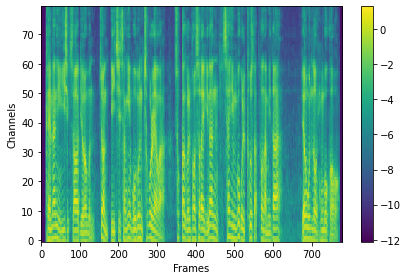

In [10]:
# Plot Mel Frame
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

fig, ax = plt.subplots()
im = ax.imshow(y_gen_tst.numpy()[0], aspect="auto", origin="lower",
                interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()
plt.show()

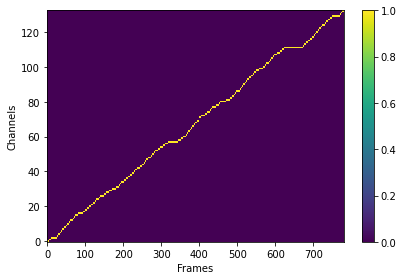

In [11]:
# Plot Attention Alignment
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

fig, ax = plt.subplots()
im = ax.imshow(attn_gen.numpy()[0][0], aspect="auto", origin="lower",
                interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()
plt.show()

In [ ]:
# Save Mel-Spec
np.save(f"meloutput.npy", y_gen_tst.numpy())